## Chemical Evolution

### This notebook go through the basic idea of chemical evolution model 


### We start with close box model to see what we might need to describe the chemical evolution of the galaxy. 
### We will then generalized the model by adding gas flows 


In [1]:
import numpy as np
from scipy.integrate import odeint, quad
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d



def near_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# stellar yields
# reference for z2e-2 and z1e-3 : https://ui.adsabs.harvard.edu/abs/1992A%26A...264..105M/abstract 
# reference for z1e-5 and z4e-3 : https://ui.adsabs.harvard.edu/abs/2002A%26A...390..561M/abstract
'''
z1 = np.genfromtxt('z1e-5.txt', names=True)
z2 = np.genfromtxt('z1e-3.txt', names=True)
z3 = np.genfromtxt('z4e-3.txt', names=True)
z4 = np.genfromtxt('z2e-2.txt', names=True)
stellar_yield_table = [z1, z2, z3, z4]
sty_value = [1e-5, 1e-3, 4e-3, 2e-2]
'''

# Mo 2010 textbook table: stellar yields and mass eject mass 
z_MMW = np.genfromtxt('data/z_MMW.txt', names=True)

## Fuction: 

### OA: input absolute metallicity Z, output 12+log(O/H)
### invOA: inverse of OA()
### IMF: initial mass function (Kroupa, for simplicity)

In [2]:
##  Astronomy functions: 

# this convert absolute metallicity to 12+log(O/H)
def OA(Z): return 12+np.log10(Z*0.4/16/0.74)
def invOA(Metal): return 0.74*16/0.4*np.power(10, Metal-12)

def IMF(m):#Kroupa IMF 
    norm = 1/5.143486  # normalization term
    if m > 100:return 0
    if m<=0.08:return norm*np.power(m, -0.3)
    if m>=0.5: return norm*np.power(m, -2.3)
    else:      return norm*np.power(m, -1.3)
    
#calcualte the normalization term 
#norm = quad( lambda x: IMF(x) , 0, 100, maxp1 = 200, limit = 200)
#print(norm)



## Close box model: 

### For a close box, the total mass M$_{tot}$ is conserved: M$_{tot}$ = M$_{gas}$ + M$_{*}$
### The gas forms stars, and the stars return gas to ISM with stellar winds and at the end of their lifetime. 

## (1) $\frac{d M_{gas}(t)}{dt} = - \psi(t) + EJ(t)$, 
### where $\psi(t)$ is star formation rate and $EJ(t)$ is the return rate (or eject rate; the rate at which the stars return mass to the gas phase by stellar winds and supernovae). 

### If we denote $m$ as the initial mass of a star, and $\phi(m)$ as the IMF, then $EJ(t)$ can be expressed as: 

## (2) $EJ(t) = \int^\infty_{m_\tau} m~f^{ej}(m)~\psi(t - \tau_m)~\phi(m) ~dm/M_\odot$, 

### where $m_\tau$ is the mass of a star with lifetime of $\tau$, $f^{ej}(m)$ is the fration of a star's initial mass that is ejected.


### If we assume the gas are uniformly mixed (well mixed), then the evolution of metals will be parallel to the evolution of the total mass: 

## (3) $\frac{d Z~M_{gas}(t)}{dt} = - Z~\psi(t) + EJ_Z(t)$, 
### where Z is the mass fraction of the element  (gas phase metallicity, $Z \equiv M_Z / M_{gas}$ ). 

### The metal return rate $EJ_Z(t)$ is also parallel: 
## (4) $EJ_Z(t) = \int^\infty_{m_\tau} m~f_Z^{ej}(m)~\psi(t - \tau_m)~\phi(m) ~dm/M_\odot$,
### $f_Z^{ej}(m)$ is the stellar yield, which is the return fraction of the metal to the intial stellar mass.   


### Under the instantaneous recycling approximation, all stars above a limit $m_{lim}$ have negligible lifetime and immidiately return the mass into ISM, and all stars below this limit have very long life time and never return masses.   In this cas,  the integral lower limit $m_\tau$ can be replaced with $m_{lim}$, and $\psi(t - \tau_m)$ can be replaced as $\psi(t)$.  

### We can rewrite equation (2) as: 
## (2') $EJ(t) = \psi(t)~RR = \psi(t) \int^\infty_{m_{lim}} m~f^{ej}(m)~~\phi(m) ~dm/M_\odot$, 
### where $RR$ is the return fraction. ( The newly formed stars imidiately return the mass at this fraction ) 
### Note that $RR$ is a constant once the IMF and eject fraction $f^{ej}(m)$ is decided.

### The metal yield $y_Z$ is defined as the ratio between the mass of "newly produced" metals to the total mass that remains locked in the remnant : 

## $y_Z = \frac{RR_Z}{1-RR} = \frac{1}{1-RR} \int^\infty_{m_{lim}} m~f_Z^{ej}(m)~~\phi(m) ~dm/M_\odot$.

### The integral on the right hand side ($RR_Z$) is the ratio between the mass of  newly produced metals to the newly produced stellar mass. 

### The equation (4) can then be expressed with the metal yield: 
## (4') $ ER_Z(t) = \psi(t) [ RR~Z(t) + y_Z \times (1-RR) ] $
### The first term in the bracket is the returned newly produced metals , the second turn in the bracket is the returned  initial metals (and some gets locked in the remnant). 

### With a boundary condition, we can solve (1), (2'), (3), (4').  

In [3]:
### In this cell we define function f_ej, fej_z.  We integrate them over mass and IMF to get RR and yZ. 

def fej(m):  #stellar eject fraction , simplified
    x = z_MMW['Ms']
    y = z_MMW['Mej']
    ejm = interp1d(x, y)
    return ejm(m)/m

def rr(m): #return rate function
    return m*fej(m)*IMF(m) 

'''    
def stellar_yield(m, element = 'O'): 
    Z = 1e-3
    idx = near_idx(sty_value, Z)
    ztab = stellar_yield_table[idx]
    con = ztab['v'] == 0
    x = ztab['M'][con]
    y = ztab[element][con]
    sty = interp1d(x, y)
    return sty(m)/m
'''

def fej_Z(m, element = 'O'):  
    # the stellar yield function 
    x = z_MMW['Ms']
    y = z_MMW[element]
    sty = interp1d(x, y)
    return sty(m)/m

def zrr(m, atom='O'): #return rate function
    return m*fej_Z(m,atom)*IMF(m)
    

RR = quad( rr , 0, 100, maxp1 = 200, limit = 200)[0]
yz = 1/(1-RR)*quad( zrr , 0, 100, maxp1 = 200, limit = 200)[0]


/Users/linyuheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


## The behavior of the close model: 

### Here we discuss more details about the close model.  These details are irrelevant to the differential equations mentioned above.  They are merely a simplified description of how the code works and how the galaxy grows. 

### (1) the close_model(.) takes the argument Gal, t, where "Gal" is the condition at time step t. 
### (2) The "Gal" contains three channels: Gal[0] is total mass, Gal[1] is gas mass, Gal[2] is oxygen ratio (Z). 
### (3) SFR = 2e-3 M$_{gas}$.  This is purely hand-crafted.  You can modified this to a more realistic equation. 
### (4) For the metallicity, we trace the total metal mass devided be the gas mass (Z = M$_Z$/M$_{gas}$)
### (5) close_model(.)  output "dGal", the differential of the current time step of "Gal".  

In [4]:
def close_model(Gal,t):
    Mtot = Gal[0] 
    Mg = Gal[1]
    Z = Gal[2]

    SFR = 2e-3*Mg
    ER  = RR*SFR 
    EZ = SFR*(RR*Z + yz*(1-RR))

    dMtot = 0.
    dMdt = -SFR + ER
    dZdt = (-Z*SFR + EZ - Z*dMdt)/Mg
    return [ dMtot,dMdt , dZdt]


## Flow model 

### In the flow model, we simply introduce two additional terms: 
### Outflow rate , propotional to SFR, and the eject mass ratio (RR, which is a constant). 
### Inflow rate , propotional to halo mass, and halo mass is a fuction of time and total mass. 

### Again, the behavior of the inflow and outflow here are made up.  You can modified it to a more physical realistic equation. 

### For each time step, the total mass changes by Inflow + Outflow 
### And those changes are all in gas phase.
### The gas phase metallicity also changes by inflow dillution and outflow blows away.  

In [5]:
# a_eff is the accretion coefficient 
a_eff = 0.2
def flow_model(Gal,t): 
    Mtot = Gal[0]
    Mg = Gal[1]
    Z = Gal[2]



    SFR = 2e-3*Mg
    ER  = RR*SFR 
    EZ = SFR*(RR*Z + yz*(1-RR))
    Za = 0.0005

    Mhalo = 10*Mtot+t*1e6
    
    Outflow = a_eff*RR*SFR 
    Inflow =  1e-4*Mhalo

    dMtotdt = Inflow - Outflow
    dMgdt = -SFR + ER + Inflow - Outflow
    dZdt = (-Z*SFR + EZ + Za*Inflow - Z*Outflow - Z*dMgdt)/Mg
    return [dMtotdt, dMgdt , dZdt]

In [6]:
# init con
Mtot0 = 1e11
Mg0  = 1e11-1e3
Z0 = 1e-5
print('intial 12+log(O/H)=',OA(Z0) )
# Gal0 is the inital condition "Gal"  
Gal0 = [Mtot0,Mg0,Z0]
# time steps 
t = np.geomspace(1, 1e3, 100)  #each time step is 1Myr  

intial 12+log(O/H)= 5.528708288941061


### The ODE package will solve the differential equation numerically 
### for example,  Box = odeint(close_model, Gal0, t) , close_model is our model function (input x, outupt dx), Gal0 is the initial condition, t is the time step array, Box is the solution.   

8.845253663678047


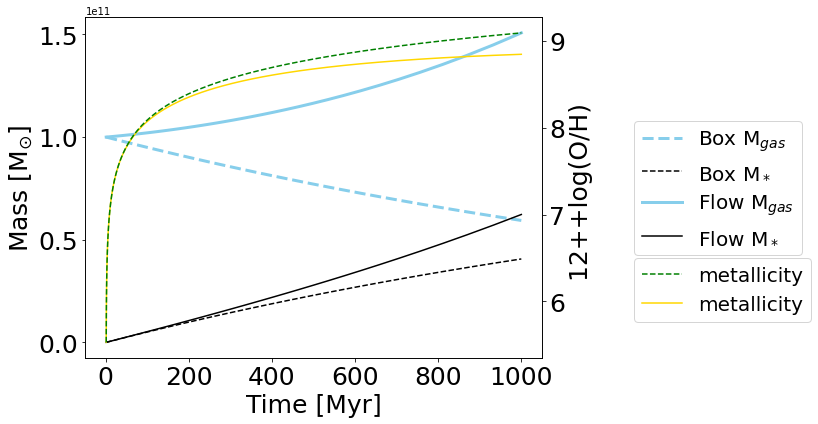

In [7]:
# sovle BOX model

Box = odeint(close_model, Gal0, t)
Mtot = Box[:,0]
Mg = Box[:,1]
Z = Box[:,2]
Ms = Mtot - Mg
BMs = Ms; BZ = Z

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax.plot(t, Mg, label = r'Box M$_{gas}$',ls='--', color='skyblue', lw=3)
ax.plot(t, Ms, label = r'Box M$_*$',ls='--', color='k')
ax2.plot(t, 12+np.log10(Z*0.4/16/0.74),ls='--', color='green' , label='metallicity') 

Gal0 = [Mtot0,Mg0,Z0]


# sovle Flow model
Gal = odeint(flow_model, Gal0, t)
Mtot = Gal[:,0]
Mg = Gal[:,1]
Z = Gal[:,2]
Ms = Mtot - Mg

print(12+np.log10(Z[-1]*0.4/16/0.74))


ax.plot(t, Mg, label = r'Flow M$_{gas}$', color='skyblue', lw=3)
ax.plot(t, Ms, label = r'Flow M$_*$', color='k')
ax2.plot(t, 12+np.log10(Z*0.4/16/0.74), color='gold',zorder=0 , label='metallicity')  


ax.set_xlabel('Time [Myr]',fontsize=25)
ax.set_ylabel(r'Mass [M$_{\odot}$]', fontsize = 25)
ax.tick_params(axis='x', labelsize= 25 )
ax.tick_params(axis='y', labelsize= 25 )

ax2.set_ylabel(r'12++log(O/H) ', fontsize = 25)
ax2.tick_params(axis='y', labelsize= 25 )



# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1.18, 0.5), fontsize=20)
ax2.legend(loc='center left', bbox_to_anchor=(1.18, 0.2), fontsize=20)

fig.tight_layout()

plt.show()

## M-Z relation

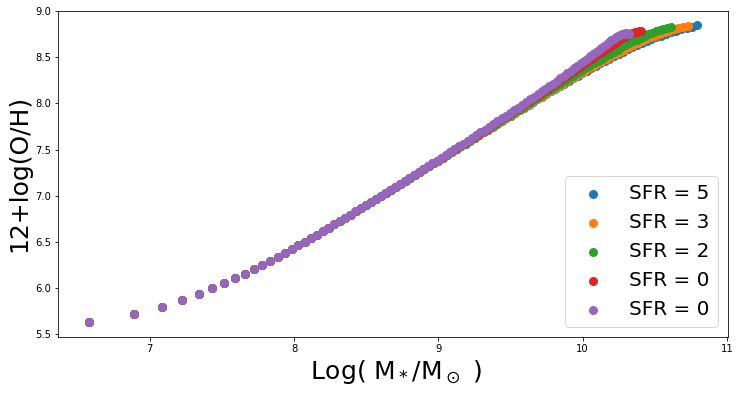

In [8]:
## M-Z relation: 

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111)

#x = np.log10(BMs[1:])
#y = OA(BZ[1:])
#ax.scatter(x, y, color='orange', lw=3, label='Box')


for i in [0.2,  0.4, 0.8, 1.6, 2]:
    # sovle Flow model
    a_eff = i
    Gal0 = [Mtot0,Mg0,Z0] 
    Gal = odeint(flow_model, Gal0, t)
    Mtot = Gal[:,0]
    Mg = Gal[:,1]
    Z = Gal[:,2]
    Ms = Mtot - Mg
    SFR = int( (Ms[-1] - Ms[-2])*1e-9 ) 
    x = np.log10(Ms[1:])
    y = OA(Z[1:])
    ax.scatter(x, y, lw=3, label=f'SFR = {SFR}')

ax.set_xlabel(r' Log( M$_*$/M$_\odot$ ) ', fontsize = 25)
ax.set_ylabel('12+log(O/H)',fontsize=25)


ax.legend(fontsize=20, loc='lower right')
plt.show()